In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from copy import deepcopy
from matplotlib import colors
from matplotlib import ticker
from sklearn.metrics import mean_squared_error

from rashomon import hasse
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache
from rashomon.aggregate import find_te_het_partitions, find_feasible_sum_subsets


%load_ext autoreload
%autoreload 2

%matplotlib inline

# Data processing

### Read data

In [2]:
dta_fname = "../Data/Does_Price_Matter_AER_merged.dta"

raw_df = pd.read_stata(dta_fname)
colnames = raw_df.columns
print(colnames)

cols_to_keep = [
                'treatment', 'control',
                'ratio',
                # 'ratio2', 'ratio3',
                'size',
                # 'size25', 'size50', 'size100', 'sizeno',
                'ask',
                # 'ask1', 'ask2', 'ask3',
                # 'askd1', 'askd2', 'askd3',
                'amount', 'gave', 'amountchange',
                'red0'#, 'blue0'
               ]
df = raw_df[cols_to_keep]

df.head()

Index(['treatment', 'control', 'ratio', 'ratio2', 'ratio3', 'size', 'size25',
       'size50', 'size100', 'sizeno', 'ask', 'askd1', 'askd2', 'askd3', 'ask1',
       'ask2', 'ask3', 'amount', 'gave', 'amountchange', 'hpa', 'ltmedmra',
       'freq', 'years', 'year5', 'mrm2', 'dormant', 'female', 'couple',
       'state50one', 'nonlit', 'cases', 'statecnt', 'stateresponse',
       'stateresponset', 'stateresponsec', 'stateresponsetminc', 'perbush',
       'close25', 'red0', 'blue0', 'redcty', 'bluecty', 'pwhite', 'pblack',
       'page18_39', 'ave_hh_sz', 'median_hhincome', 'powner', 'psch_atlstba',
       'pop_propurban'],
      dtype='object')


,treatment,control,ratio,size,ask,amount,gave,amountchange,red0
0,0,1,Control,Control,Control,0.0,0,-45.0,0.0
1,0,1,Control,Control,Control,0.0,0,-25.0,0.0
2,1,0,1,"$100,000",1x,0.0,0,-50.0,0.0
3,1,0,1,Unstated,1x,0.0,0,-25.0,0.0
4,1,0,1,"$50,000",1x,0.0,0,-15.0,1.0


### Remove control

In [3]:
# avg_control = np.mean(df[df["control"] == 1]["amountchange"])
# df_treatment = df[df["treatment"] == 1]
# df_treatment.loc[:, "amountchange"] = df_treatment.loc[:, "amountchange"] - avg_control
df_treatment = deepcopy(df)
df_treatment = df_treatment.dropna()

### Process data

In [4]:
ratio_map = {"Control": 0, 1: 1, 2: 2, 3: 3}
size_map = {"Control": 0, "$25,000": 1, "$50,000": 2, "$100,000": 3, "Unstated": 4}
ask_map = {"Control": 0, "1x": 1, "1.25x": 2, "1.50x": 3}
redblue_map = {0: 1, 1: 2}


df_treatment.loc[:, "ratio"] = df_treatment.loc[:, "ratio"].map(ratio_map)
df_treatment.loc[:, "size"] = df_treatment.loc[:, "size"].map(size_map)
df_treatment.loc[:, "ask"] = df_treatment.loc[:, "ask"].map(ask_map)
df_treatment.loc[:, "red0"] = df_treatment.loc[:, "red0"].map(redblue_map)
df_treatment = df_treatment.astype({
    "ratio": np.int64, "size": np.int64, "ask": np.int64, "red0": np.int64})

df_treatment = df_treatment.drop(["treatment", "control"], axis=1)

df_treatment.head()

,ratio,size,ask,amount,gave,amountchange,red0
0,0,0,0,0.0,0,-45.0,1
1,0,0,0,0.0,0,-25.0,1
2,1,3,1,0.0,0,-50.0,1
3,1,4,1,0.0,0,-25.0,1
4,1,2,1,0.0,0,-15.0,2


# Analysis

### Rashomon

In [5]:
def print_pools(R_set, rashomon_profiles, idx, profiles, policies_mask, all_policies=None,
               policy_means=None):
    r_set = R_set[idx]
    
    pi_policies_profiles_r = {}
    for k, profile in enumerate(profiles):
        if rashomon_profiles[k].sigma[r_set[k]] is None and rashomon_profiles[k].Q[r_set[k]] == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_mask[k]))}
            pass
        else:
            _, pi_policies_r_k = extract_pools.extract_pools(
                policies_profiles_masked[k],
                rashomon_profiles[k].sigma[r_set[k]]
            )
        pi_policies_profiles_r[k] = pi_policies_r_k
    
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    if policy_means is not None:
        pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    else:
        pool_means_r = None
    
    for k, v in pi_pools_r.items():
        if all_policies is not None:
            print(k, ":", [all_policies[x] for x in v])
        else:
            print(k, ":", v)
        if pool_means_r is not None:
            print(pool_means_r[k])

Setup the policy and profile list

In [6]:
Z = df_treatment.to_numpy()
X = Z[:, [0, 1, 2, 6]] #- 1
y = Z[:, 3] / 100 # (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

M = 4
# R = np.array([3, 4, 3])
# R = np.array([4, 5, 4, 3])
R = np.array([4, 5, 4, 2])

num_data = X.shape[0]

if R[3] == 2:
    X[:, 3] -= 1



num_profiles = 2**M
profiles, profile_map = hasse.enumerate_profiles(M)

all_policies = hasse.enumerate_policies(M, R)
num_policies = len(all_policies)

In [7]:
policies_ids_map = {}
for idx, pol in enumerate(all_policies):
    policies_ids_map[pol] = idx

In [8]:
policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if hasse.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

Setup the data and compute policy-wise means

In [9]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(hasse.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [10]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

0.022086720867208667


(array([95]),)

Run the Rashomon set

In [32]:
## Params used for arxiv + JRSSB
reg = 1e-7
q =  0.007558

## Params for graphic on presentation
# reg = 1e-7
# q =  0.0075563

# reg = 5e-2
# q =  100

R_set, R_profiles = RAggregate(M, R, np.inf, D, y, q, reg=reg, bruteforce=True, num_workers=1)
# R_set, rashomon_profiles = RAggregate(M, R, 10, D, y, q, reg=reg)

print(len(R_set))

8271


In [34]:
# best_profile_counter = np.zeros(shape=(num_profiles,))

model_losses = []
model_sizes = []
# model_mses = []
# model_best_eff = []

# model_pool_means = []
# model_pools = []
# model_policy_pool_map = []

# best_loss = np.inf
# best_policy_o = None

for r_set in R_set:
    pi_policies_profiles_r = {}

    loss_r = 0
    size_r = 0
    
    for profile, model_prof in enumerate(r_set):
        sigma_r_prof = R_profiles[profile].sigma[model_prof]
        loss_r_prof = R_profiles[profile].loss[model_prof]
        size_r_prof = R_profiles[profile].H[model_prof]

        loss_r += loss_r_prof

        if sigma_r_prof is None and loss_r_prof == 0:
            pass
        else:
            size_r += size_r_prof
    
    model_losses.append(loss_r)
    model_sizes.append(size_r)

model_losses = np.array(model_losses)
model_sizes = np.array(model_sizes)

q_0 = np.min(model_losses)

model_post_prob = np.exp(-model_losses)

print(f"Best model loss {q_0}")

Best model loss 0.0075562069110773206


In [35]:
sorted_losses = np.sort(model_losses)
sorted_indices = np.argsort(model_losses)
sorted_sizes = model_sizes[sorted_indices]
sorted_posteriors = np.exp(-sorted_losses)
map_to_model_ratio = sorted_posteriors / np.max(sorted_posteriors)

n_range = np.arange(len(sorted_posteriors))

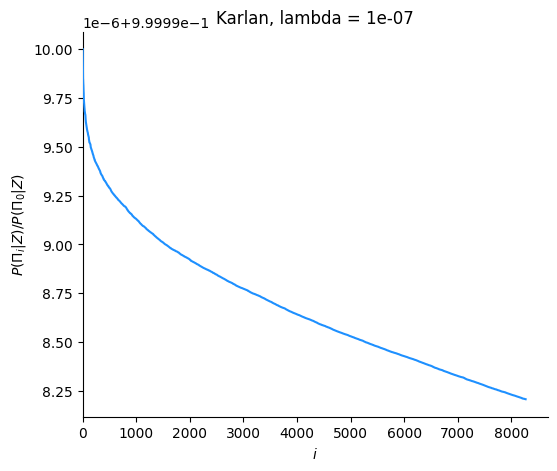

In [36]:


max_idx = 500

fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)

# ax.plot([our_threshold, our_threshold], [0, 2], color="black", ls="--")

ax.plot(n_range, map_to_model_ratio,
        color="dodgerblue",
       zorder=3.1)
# ax.plot(n_range[:max_idx], map_to_model_ratio[:max_idx],
#         linewidth=3,
#         color="forestgreen",
#        zorder=3.1)

ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$P(\Pi_i | Z) / P(\Pi_0 | Z)$", rotation=90)

# ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0) #, np.max(n_range))
# ax.set_ylim(0, np.max(map_to_model_ratio))
# ax.set_xlim(0, np.max(n_range))
# ax.set_ylim(0)
# ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_title(f"Karlan, lambda = {reg}")

plt.show()

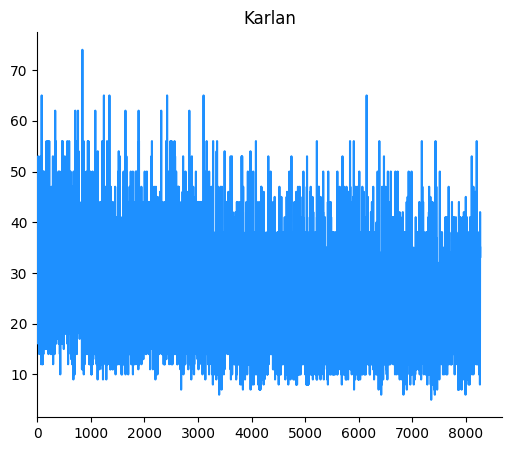

In [37]:


max_idx = 500

fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)

# ax.plot([our_threshold, our_threshold], [0, 2], color="black", ls="--")

ax.plot(n_range, sorted_sizes,
        color="dodgerblue",
       zorder=3.1)

# ax.set_xlabel(r"$i$")
# ax.set_ylabel(r"$P(\Pi_i | Z) / P(\Pi_0 | Z)$", rotation=90)

# ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0) #, np.max(n_range))
# ax.set_ylim(0, np.max(map_to_model_ratio))
# ax.set_xlim(0, np.max(n_range))
# ax.set_ylim(0)
# ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_title("Karlan")

plt.show()

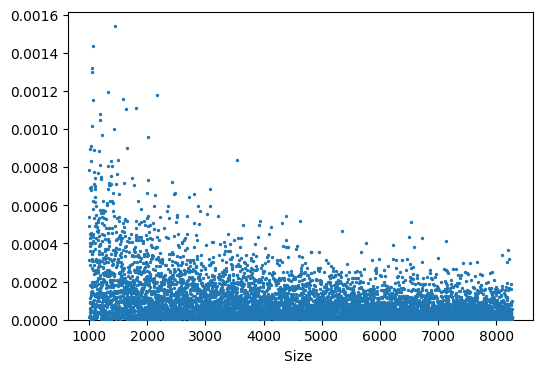

In [38]:
max_idx = 1000

sorted_losses = np.sort(model_losses)
n_range = np.arange(len(sorted_losses))

sorted_prob = np.exp(-sorted_losses)

cumsum = np.cumsum(sorted_prob)
cumsum_ratio = sorted_prob / cumsum

diff = sorted_prob[1:] - sorted_prob[:-1]
# diff = sorted_losses[1:] - sorted_losses[:-1]
diff_nrange = n_range.copy()[1:]

diff_cumsum = np.cumsum(diff)
diff_cumsum_ratio = diff / diff_cumsum

fig = plt.figure(figsize=(6, 4))

# plt.scatter(n_range, sorted_losses, s=1)
# plt.scatter(n_range, np.exp(-sorted_losses), s=1)
# plt.scatter(n_range[:max_idx], cumsum_ratio[:max_idx], s=1, zorder=3.1)
# plt.scatter(n_range[:], cumsum_ratio[:], s=1, zorder=3.1)
plt.scatter(diff_nrange[max_idx:], diff_cumsum_ratio[max_idx:], s=2, zorder=3.1)

plt.xlabel("Size ")
plt.ylabel("")

plt.ylim(0)


plt.show()

In [39]:
epsilon_est = np.max(model_losses) / np.min(model_losses) - 1
print(f"Epsilon = {epsilon_est}")

Epsilon = 0.00023728828097069332


In [ ]:
# for i in range(len(model_losses)):
#     if model_sizes[i] > 10 or model_losses[i] > q_0:
#         continue

#     sqrd_err_best_pol_i = (model_best_eff[i] - true_best_eff)**2
#     log_post_ratio = np.exp(- model_losses[i]) / np.exp(-best_loss)

#     print(f"{model_sizes[i]}: {model_mses[i]:.5e} ({model_losses[i]:.5e}) & {sqrd_err_best_pol_i:.3e} & {log_post_ratio:.6e}")

Pooling red and blue states

1. "Treatment" -> Red
2. "Control" -> Blue

In [122]:
# profiles_x, profiles_x_map = hasse.enumerate_profiles(M-1)

# te_rashomon_profiles = [[]] * len(profiles_x)

# trt_arm_idx = 3

# for x, profile_x in enumerate(profiles_x):
#     print(f"Working on feature profile {tuple(list(profile_x) + ['x'])}")
#     te_rashomon_x = []
#     seen_pairs_bytes = []

#     trt_profile = tuple(list(profile_x) + [1])
#     ctl_profile = tuple(list(profile_x) + [0])

#     trt_profile_idx = profile_map[trt_profile]
#     ctl_profile_idx = profile_map[ctl_profile]

#     trt_policies_ids = policies_ids_profiles[trt_profile_idx]
#     ctl_policies_ids = policies_ids_profiles[ctl_profile_idx]
#     tc_policies_ids = trt_policies_ids + ctl_policies_ids

#     trt_policies = policies_profiles_masked[trt_profile_idx]
#     ctl_policies = policies_profiles_masked[ctl_profile_idx]

#     # Subset data
#     mask = np.isin(D, tc_policies_ids)
#     D_tc = D[mask].reshape((-1, 1))
#     y_tc = y[mask].reshape((-1, 1))

#     for R_est_idx, R_set_i in enumerate(R_set):
#         # Get treatment and control partitions
#         sigma_trt_R_set_idx = R_set_i[trt_profile_idx]
#         sigma_trt_i = R_profiles[trt_profile_idx].sigma[sigma_trt_R_set_idx]
#         sigma_ctl_R_set_idx = R_set_i[ctl_profile_idx]
#         sigma_ctl_i = R_profiles[ctl_profile_idx].sigma[sigma_ctl_R_set_idx]

#         if sigma_trt_i is None:
#             trt_bytes_rep = str.encode("None")
#         else:
#             trt_bytes_rep = sigma_trt_i.tobytes()
#         if sigma_ctl_i is None:
#             ctl_bytes_rep = str.encode("None")
#         else:
#             ctl_bytes_rep = sigma_ctl_i.tobytes()
#         bytes_rep = trt_bytes_rep + ctl_bytes_rep

#         if bytes_rep in seen_pairs_bytes:
#             continue
#         seen_pairs_bytes.append(bytes_rep)

#         # if sigma_trt_i is None or sigma_ctl_i is None:
#         #     te_rashomon_x_i = RashomonSet(shape=None)
#         #     te_rashomon_x_i.P_qe = [None]
#         #     Q_ctl = R_profiles[trt_profile_idx].Q[sigma_trt_R_set_idx]
#         #     Q_trt = R_profiles[ctl_profile_idx].Q[sigma_ctl_R_set_idx]
#         #     te_rashomon_x_i.Q = np.append(te_rashomon_x_i.Q, Q_ctl + Q_trt)

#         # else:
#         #     # if sigma_trt_i is None:
#         #     #     print("Trt is None")
#         #     #     print(policies_ids_profiles[trt_profile_idx])
#         #     #     print(policies_ids_profiles[ctl_profile_idx])
#         #     #     print(tc_policies_ids)
#         #     #     print(D_tc.shape)
#         #     #     print(R)
#         #     # if sigma_ctl_i is None:
#         #     #     print("Ctl is None")
#         #     te_rashomon_x_i = find_te_het_partitions(
#         #         sigma_trt_i, sigma_ctl_i, trt_profile_idx, ctl_profile_idx, trt_policies, ctl_policies,
#         #         trt_arm_idx, all_policies, policies_ids_profiles,
#         #         D_tc, y_tc, policy_means,
#         #         theta=q, reg=reg, normalize=num_data
#         #     )

#         # print(R_est_idx, len(te_rashomon_x_i.sigma))
#         # for idx, sigma_idx in enumerate(te_rashomon_x_i.sigma):
#         #     q_idx = te_rashomon_x_i.Q[idx]
#         #     te_rashomon_x.append((sigma_idx, q_idx, sigma_trt_i, sigma_ctl_i))

#     # te_rashomon_profiles[x] = te_rashomon_x

Working on feature profile (0, 0, 0, 'x')
Working on feature profile (0, 0, 1, 'x')
Working on feature profile (0, 1, 0, 'x')
Working on feature profile (0, 1, 1, 'x')
Working on feature profile (1, 0, 0, 'x')
Working on feature profile (1, 0, 1, 'x')
Working on feature profile (1, 1, 0, 'x')
Working on feature profile (1, 1, 1, 'x')


### Analyzing the rashomon set

First, we study model sizes

In [40]:
R_set_pruned = []
model_losses_2 = []
model_sizes_2 = []
# model_mses_2 = []
# model_best_eff_2 = []
# model_pool_means_2 = []
# model_pools_2 = []
# model_policy_pool_map_2 = []

eps_pruned = 1e-4
threshold = q_0 * (1 + eps_pruned)

for i in range(len(R_set)):
    if model_losses[i] > threshold:
        continue

    R_set_pruned.append(R_set[i])
    model_losses_2.append(model_losses[i])
    model_sizes_2.append(model_sizes[i])
    # model_mses_2.append(model_mses[i])
    # model_best_eff_2.append(model_best_eff[i])
    # model_pool_means_2.append(model_pool_means[i])
    # model_pools_2.append(model_pools[i])
    # model_policy_pool_map_2.append(model_policy_pool_map[i])

model_losses_2 = np.array(model_losses_2)
model_sizes_2 = np.array(model_sizes_2)
model_post_prob_2 = np.exp(-model_losses_2)

rel_post_prob_ratio_2 = (model_post_prob_2 - np.max(model_post_prob)) / np.max(model_post_prob)

min_post_prob_ratio_2 = np.min(rel_post_prob_ratio_2)

print(min_post_prob_ratio_2)

-7.552713265414752e-07


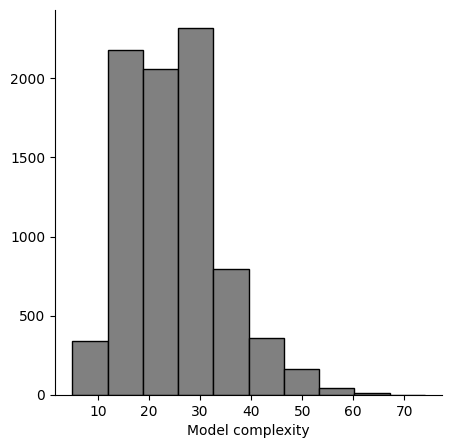

In [41]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes,
        color="grey", edgecolor="black")

ax.set_xlabel("Model complexity")
ax.set_ylabel("")
ax.set_title("")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/price_charity/rset_size_dist_full.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [42]:
scaled_post_prob = model_post_prob - np.min(model_post_prob)
scaled_post_prob = model_post_prob / np.max(model_post_prob)

rel_post_prob_ratio = (model_post_prob - np.max(model_post_prob)) / np.max(model_post_prob)

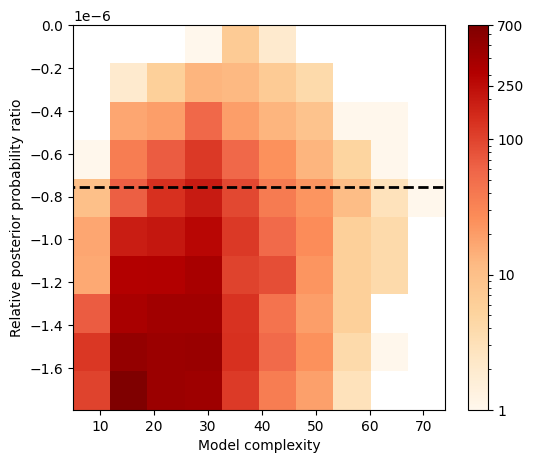

In [44]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes, rel_post_prob_ratio, norm=colors.LogNorm(),
              # vmin=0, vmax=77,
             cmap="OrRd")

ax.plot([-2, 80], [min_post_prob_ratio_2, min_post_prob_ratio_2],
       color="black", linestyle="--", linewidth=2)


cb = fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)
ticks = [1, 10, 100, 250, 700]
cb.set_ticks(ticks)
cb.set_ticklabels(ticks)

ax.set_xlabel("Model complexity")
ax.set_ylabel("Relative posterior probability ratio")


# plt.savefig("../Figures/price_charity/rset_2d_hist_cutoff.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_2d_hist_full.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

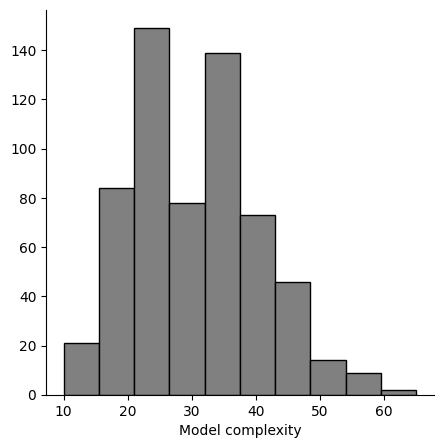

In [45]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes_2,
        color="grey", edgecolor="black")

ax.set_xlabel("Model complexity")
ax.set_ylabel("")
ax.set_title("")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/price_charity/rset_size_dist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

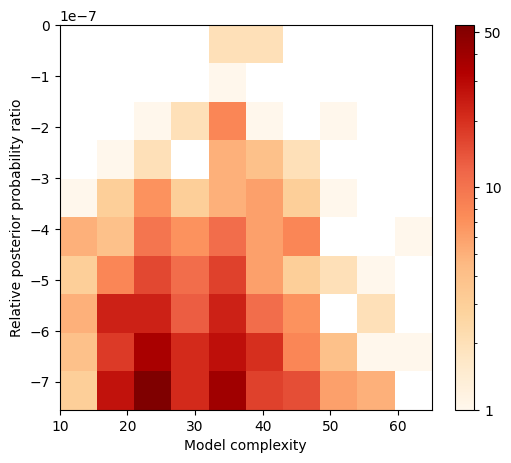

In [46]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes_2, rel_post_prob_ratio_2, norm=colors.LogNorm(),
             cmap="OrRd")

cb = fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)
cb.update_ticks()
ticks = [1, 10, 50]
cb.set_ticks(ticks)
cb.set_ticklabels(ticks)

ax.set_xlabel("Model complexity")
ax.set_ylabel("Relative posterior probability ratio")


# plt.savefig("../Figures/price_charity/rset_2d_hist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

Next, we look at the most common splits

In [47]:
print(profiles[14])
print(profiles[15])

(1, 1, 1, 0)
(1, 1, 1, 1)


In [48]:
# splits_1 = np.zeros(rashomon_profiles[1].sigma[0].shape)
splits_1 = np.zeros(R_profiles[14].sigma[0].shape)
splits_2 = np.zeros(R_profiles[15].sigma[0].shape)

price_match_1 = 0
price_match_2 = 0

for r_set in R_set_pruned:
    idx_1 = r_set[1]
    idx_2 = r_set[15]

    splits_1 += np.abs(R_profiles[14].sigma[idx_1] - 1)
    splits_2 += np.abs(R_profiles[15].sigma[idx_2] - 1)

    price_match_1 += np.ma.masked_invalid(R_profiles[14].sigma[idx_1][0,:]).max()
    price_match_2 += np.ma.masked_invalid(R_profiles[14].sigma[idx_2][0,:]).max()

splits_1 = splits_1 / len(R_set_pruned) * 100
splits_2 = splits_2 / len(R_set_pruned) * 100

price_match_1 = price_match_1 / len(R_set_pruned) * 100
price_match_2 = price_match_2 / len(R_set_pruned) * 100

In [49]:
splits_1, price_match_1

(array([[  0., 100.,  inf],
        [100.,   0.,   0.],
        [100.,   0.,  inf]]),
 100.0)

In [50]:
splits_2, price_match_2

(array([[ 60.97560976,  55.12195122,          inf],
        [100.        ,  21.13821138,  87.15447154],
        [ 72.5203252 ,  97.07317073,          inf],
        [         inf,          inf,          inf]]),
 64.0650406504065)

Price match slopes

In [51]:
zer_middle_policies = hasse.enumerate_policies(2, [5, 4])
middle_policies = []
for pol in zer_middle_policies:
    if pol[0] > 0 and pol[1] > 0:
        middle_policies.append(pol)

dems_price_match_2_eff_matrix = [[] for _ in range(len(middle_policies))]
dems_price_match_3_eff_matrix = [[] for _ in range(len(middle_policies))]
reps_price_match_2_eff_matrix = [[] for _ in range(len(middle_policies))]
reps_price_match_3_eff_matrix = [[] for _ in range(len(middle_policies))]
    

normalized_model_post_prob = model_post_prob_2 / np.sum(model_post_prob_2)

for r, r_set in enumerate(R_set_pruned):
    
    pi_policies_profiles_r = {}
    for profile, model_prof in enumerate(r_set):
        sigma_r_prof = R_profiles[profile].sigma[model_prof]
        loss_r_prof = R_profiles[profile].loss[model_prof]
        # size_r_prof = R_profiles[profile].pools[model_prof]
    
        if profile == 14 and np.ma.masked_invalid(sigma_r_prof[0, :]).max() == 1:
            consider_dem = True
            
        if profile == 15 and np.ma.masked_invalid(sigma_r_prof[0, :]).max() == 1:
            consider_rep = True
    
        # loss_r += loss_r_prof
    
        if sigma_r_prof is None and loss_r_prof == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_profiles_masked[k]))}
            # pass
        else:
            # size_r += size_r_prof
            _, pi_policies_r_k = extract_pools.extract_pools(policies_profiles_masked[profile], sigma_r_prof)
        
        pi_policies_profiles_r[profile] = pi_policies_r_k
    # print(pi_policies_r)
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    
    # if consider_dem:
    for idx, middle_pol in enumerate(middle_policies):
        middle_pol = list(middle_pol)
    
        dem_id = 0
        
        price_match_1_pol = tuple([1] + middle_pol + [dem_id])
        price_match_2_pol = tuple([2] + middle_pol + [dem_id])
        price_match_3_pol = tuple([3] + middle_pol + [dem_id])
        
        price_match_1_id = policies_ids_map[price_match_1_pol]
        price_match_2_id = policies_ids_map[price_match_2_pol]
        price_match_3_id = policies_ids_map[price_match_3_pol]
        
        price_match_1_pool = pi_policies_r[price_match_1_id]
        price_match_2_pool = pi_policies_r[price_match_2_id]
        price_match_3_pool = pi_policies_r[price_match_3_id]
        
        price_match_2_eff = pool_means_r[price_match_2_pool] - pool_means_r[price_match_1_pool]
        price_match_3_eff = pool_means_r[price_match_3_pool] - pool_means_r[price_match_1_pool]

        dems_price_match_2_eff_matrix[idx] += [price_match_2_eff]
        dems_price_match_3_eff_matrix[idx] += [price_match_3_eff]
    
        rep_id = 1
        
        price_match_1_pol = tuple([1] + middle_pol + [rep_id])
        price_match_2_pol = tuple([2] + middle_pol + [rep_id])
        price_match_3_pol = tuple([3] + middle_pol + [rep_id])
        
        price_match_1_id = policies_ids_map[price_match_1_pol]
        price_match_2_id = policies_ids_map[price_match_2_pol]
        price_match_3_id = policies_ids_map[price_match_3_pol]
        
        price_match_1_pool = pi_policies_r[price_match_1_id]
        price_match_2_pool = pi_policies_r[price_match_2_id]
        price_match_3_pool = pi_policies_r[price_match_3_id]
        
        price_match_2_eff = pool_means_r[price_match_2_pool] - pool_means_r[price_match_1_pool]
        price_match_3_eff = pool_means_r[price_match_3_pool] - pool_means_r[price_match_1_pool]
        
        reps_price_match_2_eff_matrix[idx] += [price_match_2_eff]
        reps_price_match_3_eff_matrix[idx] += [price_match_3_eff]
                


In [52]:
dems_price_match_2_eff_matrix = np.array(dems_price_match_2_eff_matrix)
reps_price_match_2_eff_matrix = np.array(reps_price_match_2_eff_matrix)
dems_price_match_3_eff_matrix = np.array(dems_price_match_3_eff_matrix)
reps_price_match_3_eff_matrix = np.array(reps_price_match_3_eff_matrix)

all_eff = pd.Series(np.hstack([dems_price_match_2_eff_matrix.flatten(), dems_price_match_3_eff_matrix.flatten(), reps_price_match_2_eff_matrix.flatten(), reps_price_match_3_eff_matrix.flatten()]))
num_bins = 5

stddev = np.std(all_eff)
if num_bins != 3:
    bins = [min(np.min(all_eff), stddev * -(3)) - 1] + [2 * stddev * i for i in np.arange(-1, 2, 3/(num_bins - 2))] + [max(np.max(all_eff), stddev * 3) + 1]
else:
    bins = [min(np.min(all_eff), stddev * -(3)) - 1] + [0] + [max(np.max(all_eff), stddev * 3) + 1]
bins = bins[::-1]
print(bins)

[1.0118362464278594, 0.006574220242195183, 0.0, -0.006574220242195183, -1.0134896604762447]


In [53]:
zer_middle_policies = hasse.enumerate_policies(2, [5, 4])
middle_policies = []
for pol in zer_middle_policies:
    if pol[0] > 0 and pol[1] > 0:
        middle_policies.append(pol)

dems_price_match_2 = np.zeros((len(middle_policies), len(bins)))
dems_price_match_3 = np.zeros((len(middle_policies), len(bins)))
reps_price_match_2 = np.zeros((len(middle_policies), len(bins)))
reps_price_match_3 = np.zeros((len(middle_policies), len(bins)))
    
# print(middle_policies)

normalized_model_post_prob = model_post_prob_2 / np.sum(model_post_prob_2)

for r, r_set in enumerate(R_set_pruned):

    pi_policies_profiles_r = {}
    for profile, model_prof in enumerate(r_set):
        sigma_r_prof = R_profiles[profile].sigma[model_prof]
        loss_r_prof = R_profiles[profile].loss[model_prof]
        # size_r_prof = R_profiles[profile].pools[model_prof]
    
        if profile == 14 and np.ma.masked_invalid(sigma_r_prof[0, :]).max() == 1:
            consider_dem = True
            
        if profile == 15 and np.ma.masked_invalid(sigma_r_prof[0, :]).max() == 1:
            consider_rep = True
            
    
        # loss_r += loss_r_prof
    
        if sigma_r_prof is None and loss_r_prof == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_profiles_masked[k]))}
            # pass
        else:
            # size_r += size_r_prof
            _, pi_policies_r_k = extract_pools.extract_pools(policies_profiles_masked[profile], sigma_r_prof)
        
        pi_policies_profiles_r[profile] = pi_policies_r_k
    # print(pi_policies_r)
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    
    # if consider_dem:
    for idx, middle_pol in enumerate(middle_policies):
        middle_pol = list(middle_pol)
    
        dem_id = 0
        
        price_match_1_pol = tuple([1] + middle_pol + [dem_id])
        price_match_2_pol = tuple([2] + middle_pol + [dem_id])
        price_match_3_pol = tuple([3] + middle_pol + [dem_id])
        
        price_match_1_id = policies_ids_map[price_match_1_pol]
        price_match_2_id = policies_ids_map[price_match_2_pol]
        price_match_3_id = policies_ids_map[price_match_3_pol]
        
        price_match_1_pool = pi_policies_r[price_match_1_id]
        price_match_2_pool = pi_policies_r[price_match_2_id]
        price_match_3_pool = pi_policies_r[price_match_3_id]
        
        price_match_2_eff = pool_means_r[price_match_2_pool] - pool_means_r[price_match_1_pool]
        price_match_3_eff = pool_means_r[price_match_3_pool] - pool_means_r[price_match_1_pool]

        dems_price_match_2[idx, (len(bins) - 1) // 2 if price_match_2_eff == 0 else np.digitize(price_match_2_eff, bins) - (price_match_2_eff > 0)] += normalized_model_post_prob[r]
        dems_price_match_3[idx, (len(bins) - 1) // 2 if price_match_3_eff == 0 else np.digitize(price_match_3_eff, bins) - (price_match_3_eff > 0)] += normalized_model_post_prob[r]
    
        rep_id = 1
        
        price_match_1_pol = tuple([1] + middle_pol + [rep_id])
        price_match_2_pol = tuple([2] + middle_pol + [rep_id])
        price_match_3_pol = tuple([3] + middle_pol + [rep_id])
        
        price_match_1_id = policies_ids_map[price_match_1_pol]
        price_match_2_id = policies_ids_map[price_match_2_pol]
        price_match_3_id = policies_ids_map[price_match_3_pol]
        
        price_match_1_pool = pi_policies_r[price_match_1_id]
        price_match_2_pool = pi_policies_r[price_match_2_id]
        price_match_3_pool = pi_policies_r[price_match_3_id]
        
        price_match_2_eff = pool_means_r[price_match_2_pool] - pool_means_r[price_match_1_pool]
        price_match_3_eff = pool_means_r[price_match_3_pool] - pool_means_r[price_match_1_pool]

        reps_price_match_2[idx, (len(bins) - 1) // 2 if price_match_2_eff == 0 else np.digitize(price_match_2_eff, bins) - (price_match_2_eff > 0)] += normalized_model_post_prob[r]
        reps_price_match_3[idx, (len(bins) - 1) // 2 if price_match_3_eff == 0 else np.digitize(price_match_3_eff, bins) - (price_match_3_eff > 0)] += normalized_model_post_prob[r]
                


In [54]:
plots_matrices = [[dems_price_match_2.T, dems_price_match_3.T],
                  [reps_price_match_2.T, reps_price_match_3.T]]

titles = [["\$2:\$1 (Democrat)", "\$3:\$1 (Democrat)"],
          ["\$2:\$1 (Republican)", "\$3:\$1 (Republican)"]
         ]

labels_size = {1: "\$25k", 2: "\$50k", 3: "\$100k", 4: "Unstated"}
labels_ask = {1: "1x", 2: "1.25x", 3: "1.5x"}

labels = []
for pol in middle_policies:
    label_i = labels_size[pol[0]] + ", " + labels_ask[pol[1]]
    labels.append(label_i)

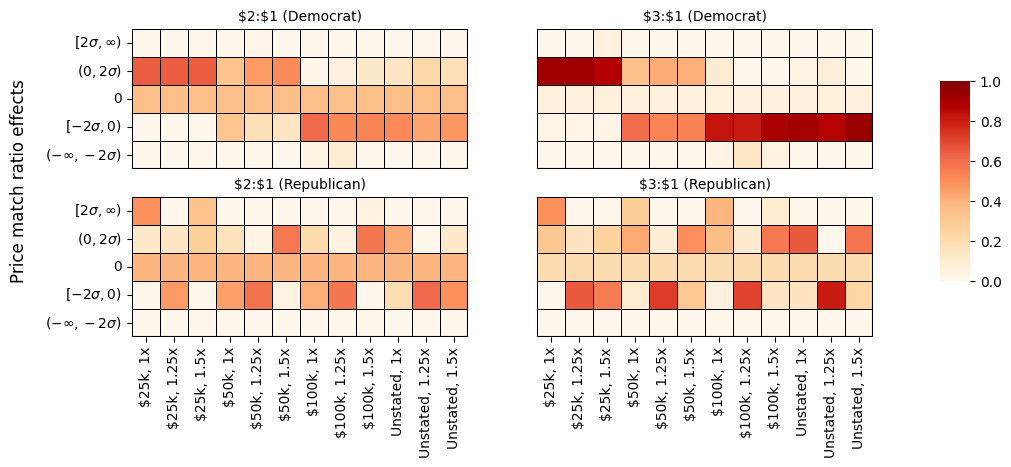

In [55]:
# plot_gender_effects = True

fig = plt.figure(figsize=(10, 4)) #layout=None, facecolor='lightblue')
gs = fig.add_gridspec(nrows=2, ncols=2, #, left=0.05, right=0.75,
        wspace=0.1)

if num_bins == 3:
    bin_labels = ["+", "0", "-"]
else:
    interval_length = 4 // (num_bins - 3)
    bin_labels = [r"$[2\sigma, \infty)$"] + [rf"$[{2 - (i + 1) * interval_length}\sigma, {2 - i * interval_length}\sigma)$" for i in range((2 // interval_length) - 1)] + [rf"$(0, {interval_length}\sigma)$"] + ["0"] + [rf"$[-{interval_length}\sigma, 0)$"] + [rf"$[{-(2 + i) * interval_length}\sigma, {-(1 + i) * interval_length}\sigma)$" for i in range((2 // interval_length) - 1)] + [r"$(-\infty, -2\sigma)$"]


cbar_ax = fig.add_axes([.95, .25, .03, .5])

for idx in range(4):
    i = idx // 2
    j = (idx % 2)

    ax_ij = fig.add_subplot(gs[i, j])
    res = sns.heatmap(
        plots_matrices[i][j],
        cmap="OrRd",
        linewidths=0.5,
        linecolor="black",
        square=True,
        vmin=0,
        vmax=1,
        ax=ax_ij,
        cbar_ax=cbar_ax
    )
    res.axhline(y=len(bins), color='black', linewidth=1.5)
    res.axvline(x=12, color='black', linewidth=1.5)
    ax_ij.set_title(titles[i][j], fontsize=10, rotation=0)
    ax_ij.set_yticks([])
    ax_ij.set_xticks([])
    if j == 0:
        ax_ij.set_yticks(np.arange(0, num_bins) + 0.5, bin_labels, rotation=0)
    if i == 1:
        ax_ij.set_xticks(np.arange(0, len(labels))+0.5, labels, rotation=90)
    # break

fig.supylabel("Price match ratio effects")

fname = f"../Figures/price_charity/price_match_mosaic_{num_bins}_bins.png"
# if plot_gender_effects:
#     fname = "../Figures/microfinance/gender/treatment_effects_mosaic_gender.png"
#     fig.supylabel("Gender-Treatment Effects")
    
# plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

### Plotting for Graphic in Presentation

In [56]:
middle_policies

12

In [126]:
dems_price_match_2_eff_matrix = np.array(dems_price_match_2_eff_matrix)
dems_price_match_3_eff_matrix = np.array(dems_price_match_3_eff_matrix)


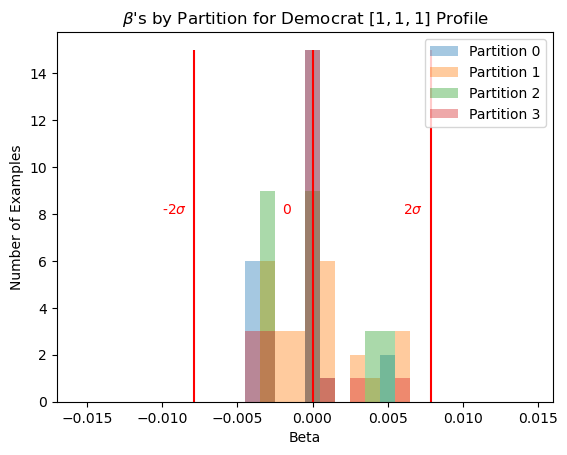

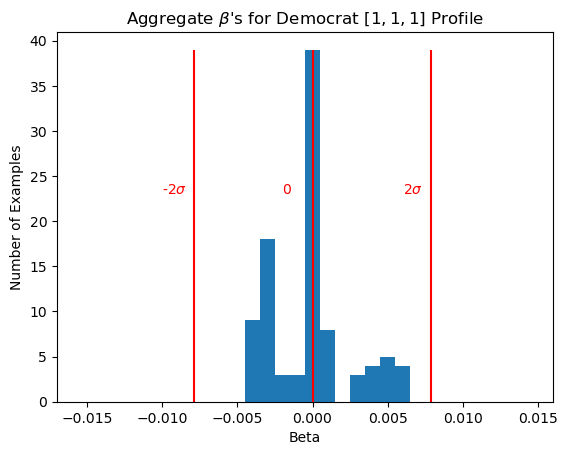

In [166]:
import seaborn as sns

for r in range(len(R_set_pruned)):
    plt.hist(x=list(dems_price_match_2_eff_matrix[:, r]) + list(dems_price_match_3_eff_matrix[:, r]), bins=[-0.0155 + 0.001 * i for i in range(0, 31)], alpha=0.4, label=f'Partition {r}')
plt.vlines([-2 * stddev, 0 * stddev, 2 * stddev], ymin = 0, ymax=15, colors='r')
plt.title(fr"$\beta$'s by Partition for Democrat $[1, 1, 1]$ Profile")
plt.xlabel("Beta")
plt.ylabel("Number of Examples")
plt.legend()
plt.text(-0.010, 8, r'-$2\sigma$', color='r')
plt.text(-0.002, 8, r'0', color='r')
plt.text(0.006, 8, r'$2\sigma$', color='r')
plt.savefig("../Figures/heatmap_explanation/charitable_per_partition_full.png")
plt.show()

plt.hist(x=list(dems_price_match_2_eff_matrix.flatten()) + list(dems_price_match_3_eff_matrix.flatten()), bins=[-0.0155 + 0.001 * i for i in range(0, 31)])
plt.vlines([-2 * stddev, 0 * stddev, 2 * stddev], ymin = 0, ymax=39, colors='r')
plt.title(fr"Aggregate $\beta$'s for Democrat $[1, 1, 1]$ Profile")
plt.xlabel("Beta")
plt.ylabel("Number of Examples")
plt.text(-0.010, 23, r'-$2\sigma$', color='r')
plt.text(-0.002, 23, r'0', color='r')
plt.text(0.006, 23, r'$2\sigma$', color='r')
plt.savefig("../Figures/heatmap_explanation/charitable_aggregate_full.png")
plt.show()

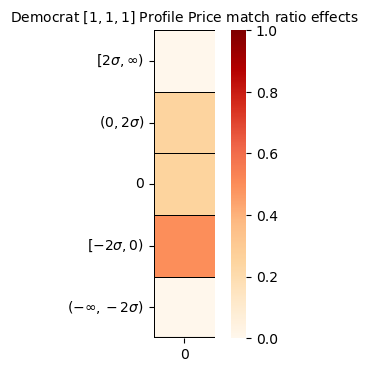

In [167]:
# plot_gender_effects = True

fig = plt.figure(figsize=(4, 4)) #layout=None, facecolor='lightblue')

if num_bins == 3:
    bin_labels = ["+", "0", "-"]
else:
    interval_length = 4 // (num_bins - 3)
    bin_labels = [r"$[2\sigma, \infty)$"] + [rf"$[{2 - (i + 1) * interval_length}\sigma, {2 - i * interval_length}\sigma)$" for i in range((2 // interval_length) - 1)] + [rf"$(0, {interval_length}\sigma)$"] + ["0"] + [rf"$[-{interval_length}\sigma, 0)$"] + [rf"$[{-(2 + i) * interval_length}\sigma, {-(1 + i) * interval_length}\sigma)$" for i in range((2 // interval_length) - 1)] + [r"$(-\infty, -2\sigma)$"]


res = sns.heatmap(
    np.mean(np.concatenate([dems_price_match_2, dems_price_match_3], axis=0), axis=0).reshape((-1, 1)),
    cmap="OrRd",
    linewidths=0.5,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=1,
)
res.axhline(y=len(bins), color='black', linewidth=1.5)
res.axvline(x=12, color='black', linewidth=1.5)
plt.yticks(np.arange(0, num_bins) + 0.5, bin_labels, rotation=0)
plt.title("Democrat $[1, 1, 1]$ Profile Price match ratio effects", fontsize=10, rotation=0)
plt.savefig("../Figures/heatmap_explanation/price_ratio_effects_heatmap_full")
plt.show()

Estimating conditional effects

In [21]:
policies_present = np.sort(np.unique(D))

beta = np.zeros(num_policies)

for i, pool_means_i in enumerate(model_pool_means_2):

    beta_i = np.zeros(num_policies)
    
    for pool_id in range(len(pool_means_i)):
        for policy in model_pools_2[i][pool_id]:
            beta_i[policy] = pool_means_i[pool_id]

    beta += beta_i * model_post_prob_2[i]

beta /= np.sum(model_post_prob_2)
beta_subset = beta[policies_present]

beta_subset_sorted = list(np.sort(beta_subset))

policy_id_1 = np.where(beta == beta_subset_sorted[-1])[0][0]
policy_id_2 = np.where(beta == beta_subset_sorted[-2])[0][0]
policy_id_3 = np.where(beta == beta_subset_sorted[-3])[0][0]
policy_id_4 = np.where(beta == beta_subset_sorted[-4])[0][0]
policy_id_worst = np.where(beta == beta_subset_sorted[0])[0][0]

print(f"Best \t\t {all_policies[policy_id_1]} \t{beta_subset_sorted[-1]}")
print(f"Second Best \t {all_policies[policy_id_2]} \t{beta_subset_sorted[-2]}")
print(f"Third Best \t {all_policies[policy_id_3]} \t{beta_subset_sorted[-3]}")
print(f"Fourth Best \t {all_policies[policy_id_4]} \t{beta_subset_sorted[-4]}")
print(f"Worst \t\t {all_policies[policy_id_worst]} \t{beta_subset_sorted[0]}")

Best 		 (2, 1, 3, 1) 	0.018785119435557104
Second Best 	 (1, 4, 2, 1) 	0.015498305514303
Third Best 	 (3, 1, 1, 1) 	0.015241985920173895
Fourth Best 	 (2, 1, 1, 1) 	0.015055374049373465
Worst 		 (1, 1, 2, 0) 	0.006650313104924555


### Plot with Red vs Blue aligned with Control

In [28]:
red_control = (0, 0, 0, 1)
blu_control = (0, 0, 0, 0)

red_control_id = 1
blu_control_id = 0


red_policies = [idx for idx, pol in enumerate(all_policies) if np.min(pol[:3]) > 0 and pol[3] == 1]
blu_policies = [idx for idx, pol in enumerate(all_policies) if np.min(pol[:3]) > 0 and pol[3] == 0]

red_blu_df = []
for r in red_policies:
    red_blu_df.append([beta[r]*100, "Red", "indianred"])
for b in blu_policies:
    red_blu_df.append([beta[b]*100, "Blue", "dodgerblue"])

red_blu_df = pd.DataFrame(red_blu_df, columns=["Effect", "State", "marker_color"])
red_blu_df.head()

,Effect,State,marker_color
0,0.886567,Red,indianred
1,1.060018,Red,indianred
2,1.498561,Red,indianred
3,0.772923,Red,indianred
4,1.069317,Red,indianred


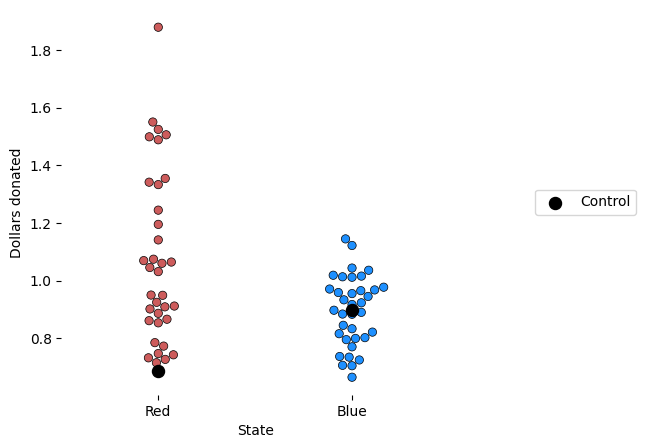

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


ax = sns.swarmplot(red_blu_df, x="State", y="Effect",
                   hue="State",
                   edgecolor="black",
                   palette=["indianred", "dodgerblue"],
                   size=6,
                   linewidth=0.5,
                  )
# ax.scatter([0]*len(red_policies), beta[red_policies]*100,
#            color="indianred", edgecolor="white", alpha=1,
#            label="Treatment (Red states)"
#           )
ax.scatter(0, beta[red_control_id]*100,
           color="black", edgecolor="black",
           zorder=3.1,
           s=75
          # label="Red Control"
          )


# ax.scatter([1]*len(blu_policies), beta[blu_policies]*100,
#            color="dodgerblue", edgecolor="white", alpha=1,
#            label="Treatment (Blue states)"
#           )
ax.scatter(1, beta[blu_control_id]*100,
           color="black", edgecolor="black",
           label="Control",
           zorder=3.1,
           s=75
          )

# ax.set_xticks([0, 1], ["Red", "Blue"])
ax.set_xlim([-0.5, 1.5])
ax.set_ylabel("Dollars donated")


ax.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))


plt.show()

In [43]:
red_te = beta[red_policies] - beta[red_control_id]
red_te_pos = len(np.where(red_te > 0)[0])
red_te_zer = len(np.where(red_te == 0)[0])
red_te_neg = len(np.where(red_te < 0)[0])

print("[Postive, Zero, Negative]")
print("Red", np.array([red_te_pos, red_te_zer, red_te_neg]) / len(red_te))

blu_te = beta[blu_policies] - beta[blu_control_id]
blu_te_pos = len(np.where(blu_te > 0)[0])
blu_te_zer = len(np.where(blu_te == 0)[0])
blu_te_neg = len(np.where(blu_te < 0)[0])

print("Blue", np.array([blu_te_pos, blu_te_zer, blu_te_neg]) / len(blu_te))

[Postive, Zero, Negative]
Red [0.97222222 0.         0.02777778]
Blue [0.5 0.  0.5]


### Plot with all policies on same axis

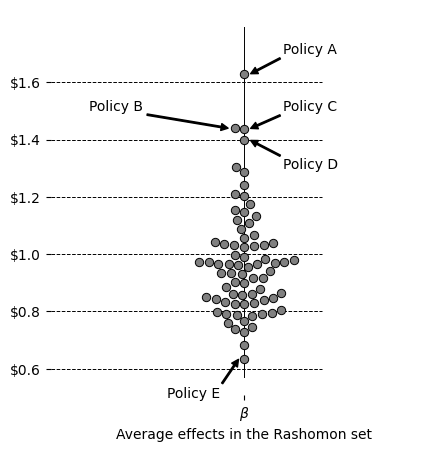

In [26]:
vert_line_x = [0, 0]
vert_line_y = [np.min(beta_subset) *0.9, np.max(beta_subset) * 1.1]

hor_line_x = [-0.5, 0.2]
hor_line_y1 = [0.016, 0.016]
hor_line_y2 = [0.006, 0.006]
hor_line_y3 = [0.012, 0.012]
hor_line_y4 = [0.014, 0.014]
hor_line_y5 = [0.008, 0.008]
hor_line_y6 = [0.010, 0.010]

fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)
ax.plot(hor_line_x, hor_line_y1, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y2, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y3, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y4, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y5, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y6, color="black", linewidth=0.7, ls="--")

ax = sns.swarmplot(beta_subset, color="gray", edgecolor="black", linewidth=0.7,
                  size=6)#, saturation=1)

ax.annotate("Policy A", xy=(0.015, beta_subset_sorted[-1]), xytext=(0.1, 0.017),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy B", xy=(-0.04, beta_subset_sorted[-2]), xytext=(-0.4, 0.015),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy C", xy=(0.015, beta_subset_sorted[-3]), xytext=(0.1, 0.015),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy D", xy=(0.015, beta_subset_sorted[-4]), xytext=(0.1, 0.013),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy E", xy=(-0.015, beta_subset_sorted[0]), xytext=(-0.2, 0.005),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01),
            label="yadadada")


ax.set_xlabel("Average effects in the Rashomon set")
ax.set_ylabel("")
ax.set_title("")
ax.set_xticks([0], [r"$\beta$"])
yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
ax.set_yticks(yticks, yticks_labels)

textstr = """
A: $2:$1, $25k, 1.5x, Blue
B: $3:$1, $25k, 1x, Blue
C: $2:$1, $25k, 1x, Blue
D: $3:$1, $25k, 1x, Blue
E: $1:$1, $50k, 1x, Red
"""
props = dict(facecolor='white', alpha=0.5,
            edgecolor='white')

# ax.text(0.5, 0.014, textstr, fontsize=10, verticalalignment='top', bbox=props)

# ax.legend([annot5.arrow_patch], (annot5["label"]))


# plt.savefig("../Figures/price_charity/conditional_effects.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [34]:
beta_red_1 = []
beta_red_2 = []
beta_blue_1 = []
beta_blue_2 = []

beta_categorical_df = []

beta_df_plot = []

policy_indicators = []

for beta_i in beta_subset:
    policy_id_i = np.where(beta == beta_i)[0][0]
    policy_i = all_policies[policy_id_i]
    this_indicator = [0, 0, 0]
    
    if policy_i[3] == 0:
        this_indicator[0] = 1
        if policy_i[0] == 1:
            this_indicator[1] = 0
            beta_blue_1.append(beta_i)
            beta_categorical_df.append([beta_i, "white", "dodgerblue", "dodgerblue", "black", "white"])
        else:
            this_indicator[1] = 1
            beta_blue_2.append(beta_i)
            beta_categorical_df.append([beta_i, "dodgerblue", "black", "dodgerblue", "black", "grey"])
    else:
        this_indicator[0] = 0
        if policy_i[0] == 1:
            this_indicator[1] = 0
            beta_red_1.append(beta_i)
            beta_categorical_df.append([beta_i, "white", "indianred", "indianred", "black", "white"])
        else:
            this_indicator[1] = 1
            beta_red_2.append(beta_i)
            beta_categorical_df.append([beta_i, "indianred", "black", "indianred", "black", "grey"])
    if policy_i[1] == 1:
        this_indicator[2] = 0
        beta_categorical_df[-1].append("white")
    else:
        this_indicator[2] = 1
        beta_categorical_df[-1].append("grey")

    policy_indicators.append(this_indicator)
    beta_df_plot.append([beta_i] + list(policy_i))

beta_categorical_df = pd.DataFrame(beta_categorical_df,
                                   columns=["beta", "color", "edge", "color_state", "edge_state", "color_ratio", "color_size"])
fill_colors = list(beta_categorical_df["color"])
edge_colors = list(beta_categorical_df["edge"])
fill_colors_state = list(beta_categorical_df["color_state"])
edge_colors_state = list(beta_categorical_df["edge_state"])
fill_colors_ratio = list(beta_categorical_df["color_ratio"])
edge_colors_ratio = list(beta_categorical_df["edge_state"])
fill_colors_size = list(beta_categorical_df["color_size"])

policy_indicators = np.array(policy_indicators)

beta_df_plot = pd.DataFrame(beta_df_plot,
                           columns=["beta", "ratio", "size", "ask", "state"])


In [35]:
beta_df_plot["ratio"] = beta_df_plot["ratio"].map({
    1: 1,
    2: 2,
    3: 2
})
beta_df_plot["size"] = beta_df_plot["size"].map({
    1: 1,
    2: 2,
    3: 2,
})
beta_df_plot["state"] = beta_df_plot["state"].map({
    0: "Blue",
    1: "Red"
})

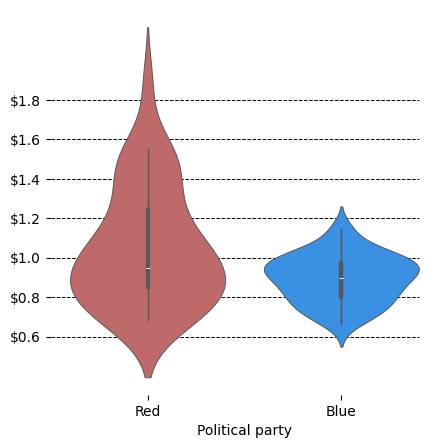

In [40]:
type = "state"


vert_line_x = [0, 0]
vert_line_x2 = [1, 1]
vert_line_y = [np.min(beta_subset) *0.9, np.max(beta_subset) * 1.1]

hor_line_y1 = [0.016, 0.016]
hor_line_y2 = [0.006, 0.006]
hor_line_y3 = [0.012, 0.012]
hor_line_y4 = [0.014, 0.014]
hor_line_y5 = [0.008, 0.008]
hor_line_y6 = [0.010, 0.010]

fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


# ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)
# ax.plot(vert_line_x2, vert_line_y, color="black", linewidth=0.7)

hor_line_x = [-0.5, 1.4]
hor_line_y_vals = [0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018]
for y_val in hor_line_y_vals:
    hor_line_y = [y_val, y_val]
    ax.plot(hor_line_x, hor_line_y, color="black", linewidth=0.7, ls="--", zorder=1)

# ax.plot(hor_line_x, hor_line_y1, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y2, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y3, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y4, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y5, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y6, color="black", linewidth=0.7, ls="--")


if type == "state":
    ax = sns.violinplot(x="state", y="beta", data=beta_df_plot[beta_df_plot["state"] == "Red"],
                        color="indianred",
                       linewidth=0.7,
                        dodge=True)
    ax = sns.violinplot(x="state", y="beta", data=beta_df_plot[beta_df_plot["state"] == "Blue"],
                        color="dodgerblue",
                       linewidth=0.7,
                        dodge=True)
elif type == "ratio":
    ax = sns.violinplot(x="ratio", y="beta", data=beta_df_plot,
                        hue="state",
                        palette=["dodgerblue", "indianred"],
                       linewidth=0.7,
                       dodge=True)
# elif type == "both":
#     ax = sns.violinplot(beta_subset, color="grey", #edgecolor=edge_colors,
#                        linewidth=0.7,
#                        # size=6,
#                        dodge=True)
elif type == "size":
    ax = sns.violinplot(x="size", y="beta", data=beta_df_plot,
                        hue="state",
                        palette=["dodgerblue", "indianred"],
                       linewidth=0.7,
                       dodge=True)


# ax.set_xlabel("Average effects in the Rashomon set")
ax.set_ylabel("")
ax.set_title("")
yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018]
yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
ax.set_yticks(yticks, yticks_labels)


# create manual symbols for legend
if type == "state":
    ax.set_xlabel("Political party")
    ax.set_xticks([0, 1], ["Red", "Blue"])
    plot_fname = "conditional_effects_state.png"
elif type == "ratio":
    ax.set_xlabel("")
    ax.set_xticks([0, 1], ["Price match \$1:\$1", "Price match > \$1:\$1"])
    plot_fname = "conditional_effects_ratio.png"
    ax.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))
elif type == "size":
    ax.set_xlabel("")
    ax.set_xticks([0, 1], ["Gift size \$25k", "Gift size > \$25k"])
    ax.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))
    plot_fname = "conditional_effects_size.png"
# elif type == "both":
#     # ax.legend(handles=[blue_1, blue_2, red_1, red_2], loc=(1, 0.35), frameon=False)
#     plot_fname = "conditional_effects_state_ratio.png"


# plt.savefig("../Figures/price_charity/" + plot_fname, dpi=300, bbox_inches="tight")

plt.show()

In [300]:
beta_red_unique = []
beta_blue_unique = []
policies_unique = []


for beta_i in beta_subset:
    policy_id_i = np.where(beta == beta_i)[0][0]
    policy_i = all_policies[policy_id_i]

    
    if policy_i[3] == 2:
        beta_blue_unique.append(beta_i)
        policies_unique.append(policy_i[:3])
    else:
        beta_red_unique.append(beta_i)

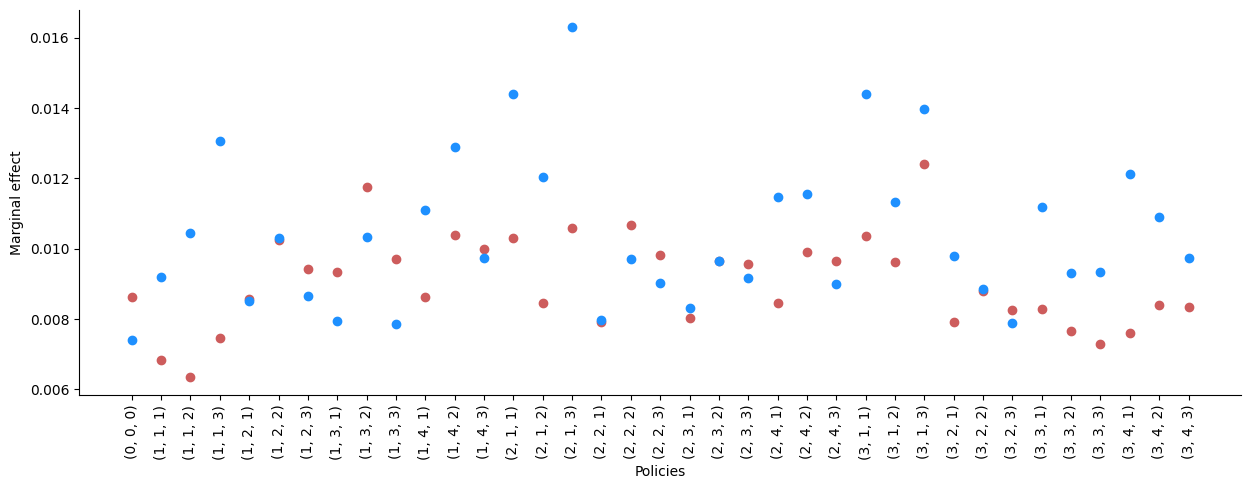

In [305]:
# vert_line_x = [0, 0]
# vert_line_y = [np.min(beta_subset) *0.9, np.max(beta_subset) * 1.1]

# hor_line_x = [-0.5, 0.2]
# hor_line_y1 = [0.016, 0.016]
# hor_line_y2 = [0.006, 0.006]
# hor_line_y3 = [0.012, 0.012]
# hor_line_y4 = [0.014, 0.014]
# hor_line_y5 = [0.008, 0.008]
# hor_line_y6 = [0.010, 0.010]

fig, ax = plt.subplots(figsize=(15,5))

ax.spines[['right', 'top']].set_visible(False)

x_vals = list(range(len(policies_unique)))

ax.scatter(x_vals, beta_red_unique, color="indianred", edgecolor="indianred")
ax.scatter(x_vals, beta_blue_unique, color="dodgerblue", edgecolor="dodgerblue")




# ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)
# ax.plot(hor_line_x, hor_line_y1, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y2, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y3, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y4, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y5, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y6, color="black", linewidth=0.7, ls="--")




ax.set_xlabel("Policies")
ax.set_ylabel("Marginal effect")
ax.set_title("")
ax.set_xticks(x_vals, policies_unique, rotation="vertical")
# yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
# yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
# ax.set_yticks(yticks, yticks_labels)



# ax.legend(handles=[blue_1, blue_2, red_1, red_2], loc=(1, 0.4), frameon=False)



# plt.savefig("../Figures/price_charity/conditional_effects.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

## Epsilon vs Size of set and error

In [58]:
sorted_losses = np.sort(model_losses)
sorted_epsilon = sorted_losses / np.min(model_losses) - 1
sorted_posteriors = np.exp(-sorted_losses)

num_models = np.arange(0, len(model_losses))+1
model_errors = sorted_losses * num_models

# est_err = 1 / (num_models * sorted_posteriors)
est_err = num_models * sorted_posteriors

max_models = 2**np.sum(R)
map_prob = sorted_posteriors[0]
norm_const_bound = max_models * map_prob

norm_const = np.sum(sorted_posteriors)
full_posterior = sorted_posteriors / norm_const
full_error = 1 / (num_models * full_posterior) - num_models * full_posterior


est_err_2 = norm_const_bound * est_err - 1/(norm_const_bound * est_err)


# our_threshold = q_0 / np.min(model_losses) - 1
# our_threshold = np.max(model_losses_2) / q_0  - 1

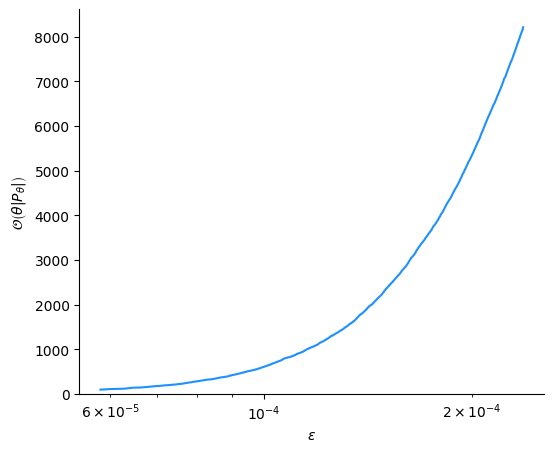

In [62]:


fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)


# ax.plot([0, np.max(sorted_epsilon)], [512, 512], color="grey", ls="--")
# ax.plot([our_threshold, our_threshold], [0, 130], color="black", ls="--")
# ax.plot([0, our_threshold], [123, 123], color="black", ls="--")

ax.plot(sorted_epsilon[100:], est_err[100:],
        color="dodgerblue",
       zorder=3.1)

# ax.plot(sorted_epsilon[100:], full_error[100:],
#         color="indianred",
#        zorder=3.1)

ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\mathcal{O} \left( \theta |P_{\theta}| \right)$", rotation=90)

# ax.set_yticks([1, 100, 200, 300, 400, 500])

# ax.set_xlim(0, np.max(sorted_epsilon))
ax.set_ylim(0) #, np.max(est_err))
ax.set_xscale("log")

# plt.savefig("../Figures/price_charity/eps_vs_est_error.png", dpi=300, bbox_inches="tight")
plt.savefig("../Figures/price_charity/eps_vs_est_error_2.png", dpi=300, bbox_inches="tight")

plt.show()

In [63]:
theta_plot = np.linspace(np.min(full_posterior), np.max(full_posterior), 1000)[::-1]

full_error = []
theta_pruned = []

for i, theta in enumerate(theta_plot):
    RPS_theta_size = len(np.where(full_posterior > theta)[0])
    size_theta_prod = theta * RPS_theta_size
    if size_theta_prod > 0:
        error_theta = 1 / size_theta_prod - size_theta_prod
        full_error.append(error_theta)
        theta_pruned.append(theta)

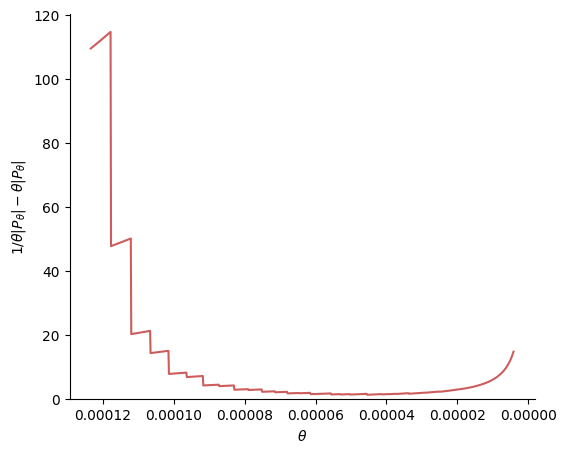

In [65]:
fig, ax = plt.subplots(figsize=(6,5))

plt.gca().invert_xaxis()

ax.spines[['right', 'top']].set_visible(False)


ax.plot(theta_pruned[100:], full_error[100:],
        color="indianred",
       zorder=3.1)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$1 / \theta |P_{\theta}| - \theta |P_{\theta}|$", rotation=90)

# ax.set_yticks([1, 100, 200, 300, 400, 500])

# ax.set_xlim(0, np.max(sorted_epsilon))
ax.set_ylim(0) #, np.max(full_error))
# ax.set_yscale("log")

# plt.savefig("../Figures/price_charity/eps_vs_est_error.png", dpi=300, bbox_inches="tight")

plt.show()

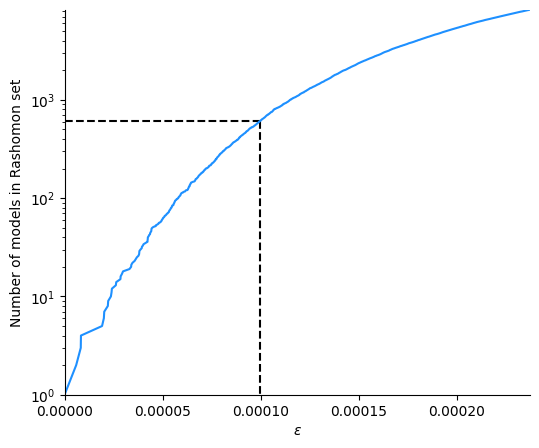

In [129]:
fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)


# ax.plot([0, np.max(sorted_epsilon)], [512, 512], color="grey", ls="--")
ax.plot([our_threshold, our_threshold], [0, len(R_set_pruned)], color="black", ls="--")
ax.plot([0, our_threshold], [len(R_set_pruned), len(R_set_pruned)], color="black", ls="--")

ax.plot(sorted_epsilon, num_models,
        color="dodgerblue")

ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel("Number of models in Rashomon set")
ax.set_yscale("log")

# ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0, np.max(sorted_epsilon))
ax.set_ylim(1, np.max(num_models))

# plt.savefig("../Figures/price_charity/eps_vs_size.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/eps_vs_size_log.png", dpi=300, bbox_inches="tight")

plt.show()

### Lasso

In [34]:
from sklearn import linear_model

In [204]:
G = hasse.alpha_matrix(all_policies)
D_matrix = hasse.get_dummy_matrix(D, G, num_policies)

In [205]:
lasso = linear_model.Lasso(1e-4, fit_intercept=False)
lasso.fit(D_matrix, y)
alpha_est = lasso.coef_
y_tva = lasso.predict(D_matrix)

In [208]:
sqrd_err = mean_squared_error(y, y_tva)
print(sqrd_err)

lasso_loss = sqrd_err + 1e-4 * np.linalg.norm(alpha_est, ord=1)
print(lasso_loss)

0.007557087681478236
0.007559423517002552


In [240]:
best_pol_effect_tva = np.max(y_tva)
sqrd_err_best_pol_tva = (true_best_eff - best_pol_effect_tva)**2
print(f"{sqrd_err_best_pol_tva:.3e}")

best_pol_idx_tva = np.unique(D[np.where(y_tva == best_pol_effect_tva)])
for idx in best_pol_idx_tva:
    print(idx, all_policies[idx])

1.079e-04
176 (2, 4, 2, 2)


In [147]:
0.0075579 / sqrd_err

1.0001074909483656

In [145]:
sqrd_err * 1.0001

0.007557843390246384

In [144]:
print(alpha_est.size)
alpha_est[np.nonzero(alpha_est)]

240


array([ 7.97690697e-03, -3.49831158e-04,  8.19950066e-03,  1.06300281e-03,
        9.43166838e-04, -8.49020667e-04,  8.90114104e-05,  6.60306624e-04,
        9.26149847e-04,  4.65184327e-04, -6.44947383e-04, -1.19132656e-03])

### Causal trees

In [182]:
from rashomon import causal_trees

from CTL.causal_tree_learn import CausalTree

In [246]:
ctl_res = causal_trees.ctl(M, R, D, y, D_matrix)
y_ctl = ctl_res[3]

In [243]:
np.unique(y_ctl)

array([0.00813755, 0.0091202 , 0.00980804, 0.01479656])

In [242]:
sqrd_err_ctl = mean_squared_error(y, y_ctl)
print(f"{sqrd_err_ctl:.3e}")

7.558e-03


In [241]:
best_pol_effect_ctl = np.max(y_ctl)
sqrd_err_best_pol_ctl = (true_best_eff - best_pol_effect_ctl)**2
print(f"{sqrd_err_best_pol_ctl:.3e}")

best_pol_idx_ctl = np.unique(D[np.where(y_ctl == best_pol_effect_ctl)])
for idx in best_pol_idx_ctl:
    print(idx, all_policies[idx])

5.315e-05
137 (2, 1, 1, 2)
140 (2, 1, 2, 2)
143 (2, 1, 3, 2)
197 (3, 1, 1, 2)
200 (3, 1, 2, 2)
203 (3, 1, 3, 2)
